In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Initial Data Cleaning

Our data set is from Kaggle and fairly large, with over 100,000 rows and 32 columns. Each row is a different reservation. Our target variable is whether or not they ended up cancelling their reservation. Our classes are imbalanced towards non cancelations but not to a huge extent (75,000 - 45,000). This may affect a logistic regression, but a more powerful model with this much data will be fine.

In [3]:
df = pd.read_csv("data/hotel_bookings.csv")
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 200

In [4]:
df.shape

(119390, 32)

In [5]:
df.is_canceled.value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

These are variables from after someone has checked in so they are not suitable for a predictive model. 

In [6]:
df = df.drop('reservation_status', axis = 1)

In [7]:
df = df.drop('reservation_status_date', axis = 1)

There is exactly one family with 10 children, the rest have 3 or less, lets just get rid of that outlier.

In [8]:
df.children.value_counts()


0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [9]:
df.children = df[df.children < 10]

We do not need the precision that day of the month or the week number provides to make a generalizable model 

In [10]:
df = df.drop('arrival_date_week_number', axis = 1)
df = df.drop('arrival_date_day_of_month', axis =1)

There are over 200 countries where people are visiting from in this data set, that will be a nightmare to make dummy variables out of and train models on, and may overfit to countries with few visitors, lets narrow it down to the top 20 and have the rest be "other".

In [11]:
df['one'] = 1
top_20_countries = df.groupby('country').sum().sort_values('one', ascending = False)[:20].index
df['top_20_c'] = df.country.apply(lambda x: x in top_20_countries)
df['country'] = np.where(df.top_20_c == True, df.country, 'other')

In [12]:
df.country.value_counts()

PRT      48590
GBR      12129
FRA      10415
ESP       8568
other     7371
DEU       7287
ITA       3766
IRL       3375
BEL       2342
BRA       2224
NLD       2104
USA       2097
CHE       1730
CN        1279
AUT       1263
SWE       1024
CHN        999
POL        919
ISR        669
RUS        632
NOR        607
Name: country, dtype: int64

In [13]:
df = df.drop('top_20_c', axis = 1)

Lets do a similar thing to company as we did for countries but only the top 10, companies with only a few reservations do not seem very predictive and could over fit the model. We will also set the NaNs (the majority of the dataset) to "no company."

In [14]:
df['company'] = df.company.astype(str)

In [15]:
df['company'] = np.where(df.company == 'nan', 'no_company', df.company)

In [16]:
top_11_companies = df.groupby('company').sum().sort_values('one', ascending = False)[:11].index
df['top_10_co'] = df.company.apply(lambda x: x in top_11_companies)


In [17]:
df['company'] = np.where(df.top_10_co == True, df.company, 'other')

In [18]:
df.company.value_counts()

no_company    112593
other           3674
40.0             927
223.0            784
67.0             267
45.0             250
153.0            215
174.0            149
219.0            141
281.0            138
154.0            133
405.0            119
Name: company, dtype: int64

In [19]:
df = df.drop('one', axis = 1)

In [20]:
df = df.drop('top_10_co', axis = 1)

Theres some pesky nans floating around.

In [21]:
df.isna().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              5
babies                                0
meal                                  0
country                               0
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             16340
company                               0
days_in_waiting_list                  0
customer_type                         0


In [22]:
df['agent'] = np.where((df['agent'].astype('str') == 'NaN')|(df['agent'].astype('str') == 'nan'), 0, 1)

Not so pesky after all, they showed us we could make the travel agent column a dummy variable between people who did and did not have an agent.

# 2. Exploratory Data Analysis

Lets figure out how much money our hotels lost on cancellations.

In [23]:
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

In [24]:
(df[df.is_canceled == 1]['total_nights'] * df[df.is_canceled == 1]['adr']).sum()

16727237.120000001

Thats a lot of cash! At the end we will show how much of this our model could save. This does not even go into the labor involved in switching reservations around or preparing different rooms. 

In [25]:
def boxplot(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=df)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();
    
def violinplot(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.violinplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=df, split = True)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();
    
def scatterplot(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.scatterplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=df, alpha = 0.5)
    s.set_xticklabels(s.get_xticklabels())
    plt.show();
       
def barplot(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.barplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=df)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();
    

In [26]:
sub = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
Title = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }

In [27]:
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_nights
0,Resort Hotel,0,342,2015,July,0,0,2,Resort Hotel,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,no_company,0,Transient,0.00,0,0,0
1,Resort Hotel,0,737,2015,July,0,0,2,Resort Hotel,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,no_company,0,Transient,0.00,0,0,0
2,Resort Hotel,0,7,2015,July,0,1,1,Resort Hotel,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,no_company,0,Transient,75.00,0,0,1
3,Resort Hotel,0,13,2015,July,0,1,1,Resort Hotel,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,1,no_company,0,Transient,75.00,0,0,1
4,Resort Hotel,0,14,2015,July,0,2,2,Resort Hotel,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,1,no_company,0,Transient,98.00,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,2,5,2,City Hotel,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,1,no_company,0,Transient,96.14,0,0,7
119386,City Hotel,0,102,2017,August,2,5,3,City Hotel,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,1,no_company,0,Transient,225.43,0,2,7
119387,City Hotel,0,34,2017,August,2,5,2,City Hotel,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,1,no_company,0,Transient,157.71,0,4,7
119388,City Hotel,0,109,2017,August,2,5,2,City Hotel,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,1,no_company,0,Transient,104.40,0,0,7


In [28]:
df["hotel"].value_counts()

City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

''

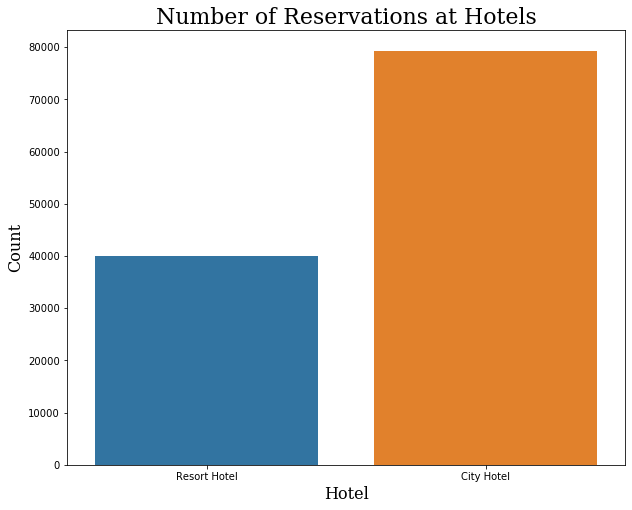

In [29]:
fig, ax = plt.subplots(figsize = (10,8))
ax=sns.countplot(x='hotel', data = df)
plt.title('Number of Reservations at Hotels', fontdict = Title)
plt.xlabel('Hotel', fontdict = sub)
plt.ylabel('Count', fontdict = sub);

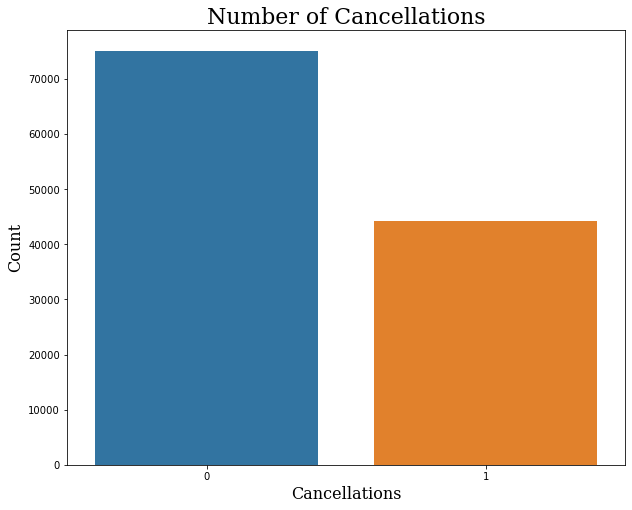

In [55]:
fig, ax = plt.subplots(figsize = (10,8))
ax = sns.countplot(x='is_canceled', data = df)
plt.title('Number of Cancellations', fontdict = Title)

plt.xlabel('Cancellations', fontdict =  sub)
plt.ylabel('Count',  fontdict = sub);
label = ["No", "Yes"]
#plt.xticks(labels = label)

# 0 - Not canceled
# 1 - Canceled 

In [31]:
df.groupby(['hotel', 'arrival_date_year'])['is_canceled'].sum() #number of cancellations per year for each hotel

hotel         arrival_date_year
City Hotel    2015                  6004
              2016                 15407
              2017                 11691
Resort Hotel  2015                  2138
              2016                  4930
              2017                  4054
Name: is_canceled, dtype: int64

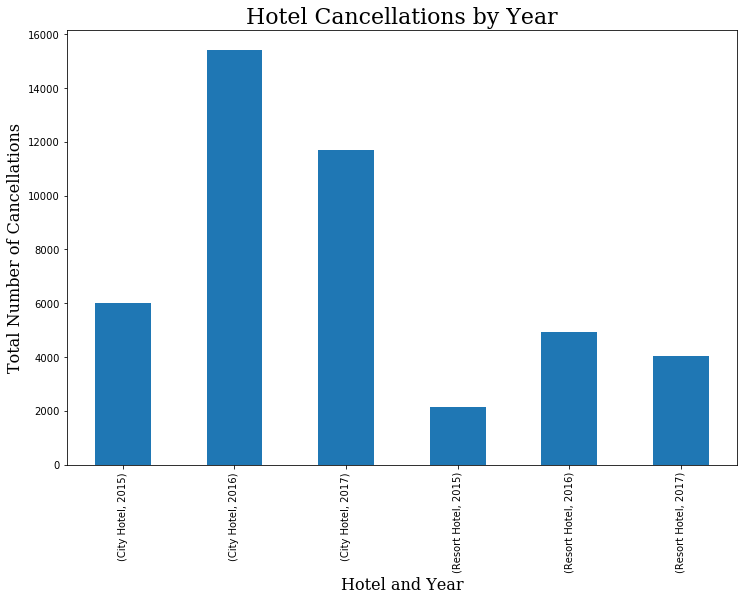

In [46]:
df.groupby(['hotel', 'arrival_date_year'])['is_canceled'].sum().plot.bar(figsize=(12,8)) # plotting the above information
plt.title('Hotel Cancellations by Year', fontdict = Title)
plt.ylabel('Total Number of Cancellations', fontdict = sub)
plt.xlabel("Hotel and Year", rotation = 0, fontdict=sub)
ax.xaxis.set_tick_params(rotation=45);

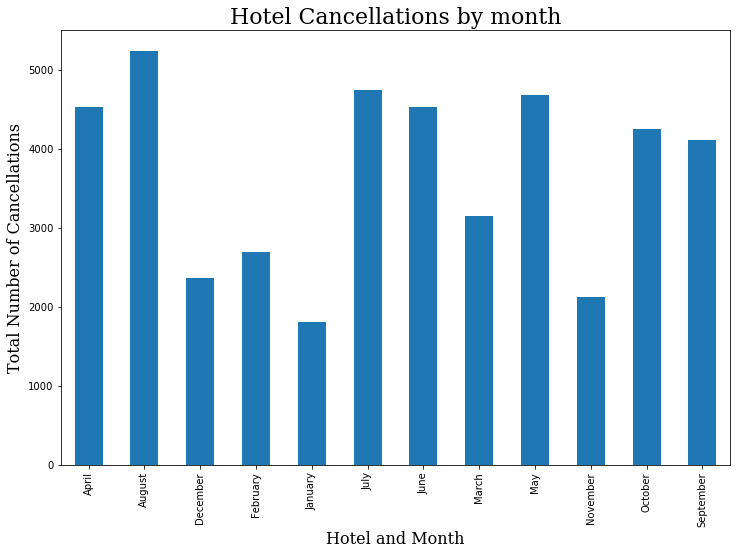

In [56]:
df.groupby(['arrival_date_month'])['is_canceled'].sum().plot.bar(figsize=(12,8)) # plotting the above information
plt.title('Hotel Cancellations by month', fontdict = Title)
plt.ylabel('Total Number of Cancellations', fontdict = sub)
plt.xlabel("Hotel and Month", rotation = 0, fontdict=sub)
ax.xaxis.set_tick_params(rotation=45);

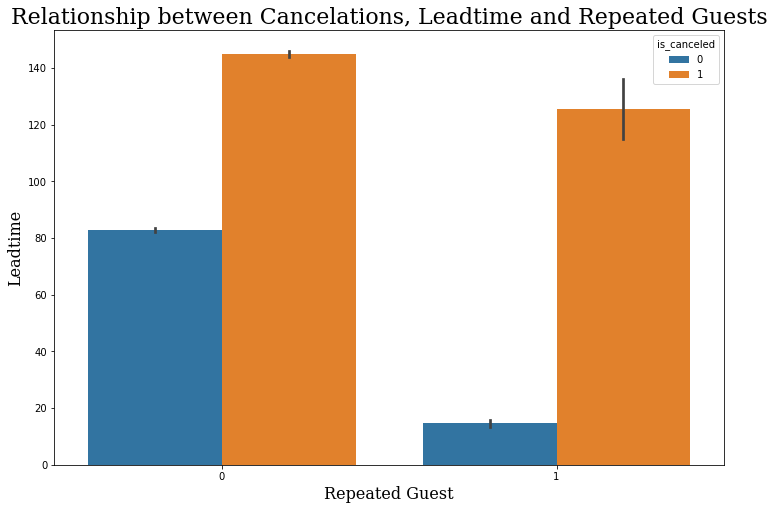

In [50]:
fig, ax = (plt.subplots(figsize = (12,8)))
sns.barplot(x="is_repeated_guest",y= "lead_time", data=df, hue="is_canceled")
plt.title("Relationship between Cancelations, Leadtime and Repeated Guests", fontdict = Title)
plt.xlabel("Repeated Guest", fontdict = sub)
plt.ylabel("Leadtime", fontdict = sub);

In [ ]:
corr = df.corr()

plt.figure(figsize = (10, 5))

ax = sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, 
                 cmap = sns.diverging_palette(20, 220, n = 200))

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right');


# 3. Feature Engineering 

Lets add a feature where somebody got a different room type than the one they reserved, as this may make them likely to cancel.

In [27]:
df['dif_room_than_res'] = np.where(df.reserved_room_type == df.assigned_room_type, 0, 1)

First lets make dummy variable out of the bevy of categorical data to make our data suited for any kind of model we choose to run.

In [28]:
df = pd.get_dummies(df, columns = ['deposit_type'], drop_first = True)
df = pd.get_dummies(df, columns = ['customer_type'], drop_first = True)
df = pd.get_dummies(df, columns = ['arrival_date_month'], drop_first = True)
df = pd.get_dummies(df, columns = ['reserved_room_type'], drop_first = True)
df = pd.get_dummies(df, columns = ['assigned_room_type'], drop_first = True)
df = pd.get_dummies(df, columns = ['meal'], drop_first = True)
df = pd.get_dummies(df, columns = ['market_segment'], drop_first = True)
df = pd.get_dummies(df, columns = ['country'], drop_first = True)
df = pd.get_dummies(df, columns = ['distribution_channel'], drop_first = True)
df = pd.get_dummies(df, columns = ['children'], drop_first = True)
df = pd.get_dummies(df, columns = ['hotel'], drop_first = True)
df = pd.get_dummies(df, columns = ['company'], drop_first = True)

Most people were not put on the waiting list at all. Lets just change it to more of a had to wair or did not have to wait column. 

In [29]:
df['had_to_wait'] = np.where(df['days_in_waiting_list']>0, 1, 0)
df = df.drop('days_in_waiting_list', axis = 1)

This feature might have colinearity issues BUT we will probably settly on a complex model that adresses this and it will help evualate the precision profit trade off I will get into later. 

In [57]:
df['total_cost'] = df.adr * df.total_nights 

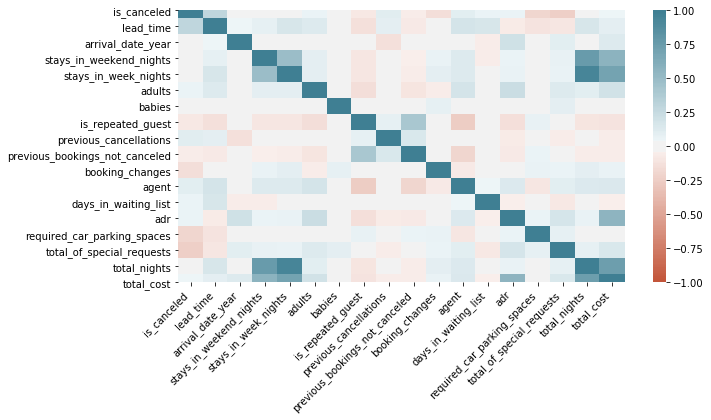

In [59]:
corr = df.corr()

plt.figure(figsize = (10, 5))

ax = sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, 
                 cmap = sns.diverging_palette(20, 220, n = 200))

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right');


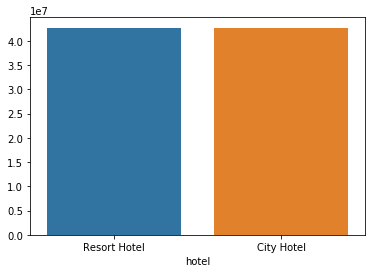

In [62]:
sns.barplot(x=df["hotel"], y=df["total_cost"].sum())

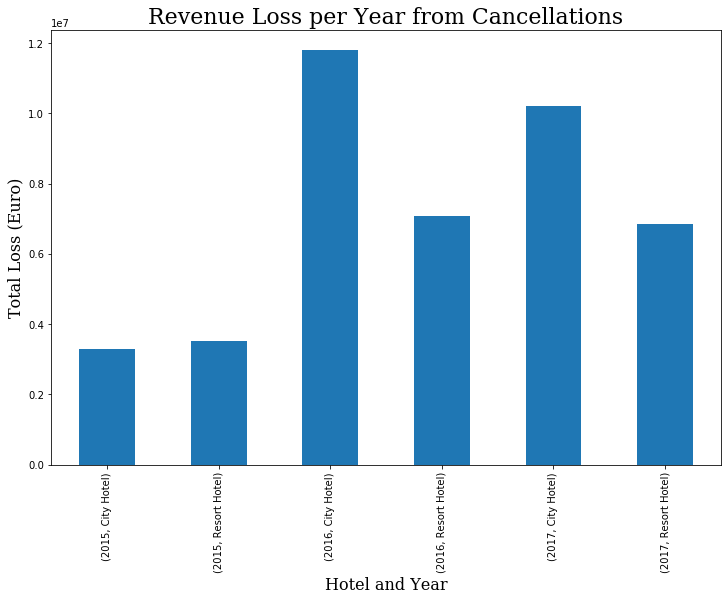

In [68]:
df.groupby(['arrival_date_year', "hotel"])['total_cost'].sum().plot.bar(figsize=(12,8))
plt.title('Revenue Loss per Year from Cancellations', fontdict = Title)
plt.ylabel('Total Loss (Euro)', fontdict = sub)
plt.xlabel("Hotel and Year", rotation = 0, fontdict=sub)
ax.xaxis.set_tick_params(rotation=45);

### Base Model - Logistic Regression, Decision Tree and Random Forest  Classifiers

Now that we can see the relationships between the features and have made dummy columns for the categorical features, we will test what the base model looks like right now and improve the model to make better predictions. 

In [31]:
from sklearn.linear_model import LogisticRegression # Import Logistic Regression
from sklearn import metrics 
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import make_scorer, accuracy_score #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import precision_score, classification_report

#### Logistic Regresion Base model

In [32]:
X = df.drop('is_canceled', axis =1)
y = df.is_canceled
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [33]:
lr = LogisticRegression (max_iter = 2000)
lr.fit(X_train, y_train)
base_lr_test_pred = lr.predict(X_test)


In [34]:

print("Precision Score: ", precision_score(y_test, base_lr_test_pred))
print ("Confusion Matrix: ", metrics.confusion_matrix(y_test, base_lr_test_pred))
print("Classification Report: ", classification_report(y_test, base_lr_test_pred))

Precision Score:  0.8127702028599934
Confusion Matrix:  [[17164  1689]
 [ 3663  7332]]
Classification Report:                precision    recall  f1-score   support

           0       0.82      0.91      0.87     18853
           1       0.81      0.67      0.73     10995

    accuracy                           0.82     29848
   macro avg       0.82      0.79      0.80     29848
weighted avg       0.82      0.82      0.82     29848



#### Random Forest Base model


In [35]:
rfc = RandomForestClassifier(random_state = 1, n_estimators=300, max_depth=10, max_features='auto')
rfc = rfc.fit(X_train, y_train)

In [61]:
base_rfc_test_pred = rfc.predict(X_test)
print("Precision Score: ", precision_score(y_test, base_rfc_test_pred))
print ("Confusion Matrix: ", metrics.confusion_matrix(y_test, base_rfc_test_pred))
print("Classification Report: ",  classification_report(y_test, base_rfc_test_pred))

Precision Score:  0.89325
Confusion Matrix:  [[17999   854]
 [ 3849  7146]]
Classification Report:                precision    recall  f1-score   support

           0       0.82      0.95      0.88     18853
           1       0.89      0.65      0.75     10995

    accuracy                           0.84     29848
   macro avg       0.86      0.80      0.82     29848
weighted avg       0.85      0.84      0.84     29848



# 4. Feature Selection

# 5. Model iterations

Since overbooking a room where someone did not cancel would be a headache, we tailored our models towards precision. AKA if we say someone is going to cancel, there is a very high chance they are. This might dip into profitabality since less rooms can be overbooked but that could be adjusted on a client by client basis. 

### Test Train Split

In [39]:
X = df.drop('is_canceled', axis =1)
y = df.is_canceled
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


### Scaling our data

In [40]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)


### Logistic Regression

In [48]:
lr = LogisticRegression (max_iter = 1000)
lr.fit(scaled, y_train)
lr_test_pred = lr.predict(scaled_test)


In [49]:
metrics.precision_score(y_test , test_pred)

0.89325

In [50]:
print("Precision Score: ", precision_score(y_test, lr_test_pred))
print ("Confusion Matrix: ", metrics.confusion_matrix(y_test, lr_test_pred))
print("Classification Report: ", classification_report(y_test, lr_test_pred))

Precision Score:  0.8083127940846964
Confusion Matrix:  [[17142  1711]
 [ 3780  7215]]
Classification Report:                precision    recall  f1-score   support

           0       0.82      0.91      0.86     18853
           1       0.81      0.66      0.72     10995

    accuracy                           0.82     29848
   macro avg       0.81      0.78      0.79     29848
weighted avg       0.82      0.82      0.81     29848



### With Ridge

In [43]:
lr = LogisticRegression (penalty = 'l1', solver='saga', max_iter = 1000)
lr.fit(scaled, y_train)
test_pred = lr.predict(scaled_test)

In [44]:
metrics.precision_score(y_test, test_pred)

0.8121546961325967

### Random Forest Model

In [45]:
rfc = RandomForestClassifier(random_state = 1, n_estimators=300, max_depth=10, max_features='auto')

In [46]:
rfc = rfc.fit(X_train, y_train)

In [47]:
test_pred = rfc.predict(X_test)
metrics.accuracy_score(y_test, test_pred)

0.8424350040203699

### With Gridsearch Hyper Paramaters 

In [ ]:
rfc = RandomForestClassifier(random_state = 1, n_estimators=300, max_depth=2, max_features='auto')

### XGBoost with GBTree

In [51]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.5, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 10, 
                           alpha = 1, 
                           n_estimators = 1000,
                           verbosity = 1,
                           booster = 'gbtree',
                          )

In [52]:
xg_clf.fit(X_train,y_train)

XGBClassifier(alpha=1, colsample_bytree=0.5, max_depth=10, n_estimators=1000,
              subsample=0.5)

In [54]:
xg_preds2 = xg_clf.predict(X_test)

In [55]:
print(precision_score(y_test, xg_preds2))
print (metrics.confusion_matrix(y_test, xg_preds2))
print(classification_report(y_test, xg_preds2))

0.860290625890398
[[17382  1471]
 [ 1937  9058]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     18853
           1       0.86      0.82      0.84     10995

    accuracy                           0.89     29848
   macro avg       0.88      0.87      0.88     29848
weighted avg       0.89      0.89      0.89     29848



# 6. Model Interpretation 